# Lending Club Analysis Using AutoML

In [1]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np

In [2]:
target='bad_loan'
min_mem_size=6 
run_time=222

In [3]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

3


In [4]:
# 65535 Highest port no
port_no=random.randint(5555,55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()
  sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:23963 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 19.0.1+10-21, mixed mode, sharing)
  Starting server from C:\Users\HP\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\HP\AppData\Local\Temp\tmp88f2mych
  JVM stdout: C:\Users\HP\AppData\Local\Temp\tmp88f2mych\h2o_HP_started_from_python.out
  JVM stderr: C:\Users\HP\AppData\Local\Temp\tmp88f2mych\h2o_HP_started_from_python.err
  Server is running at http://127.0.0.1:23963
Connecting to H2O server at http://127.0.0.1:23963 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.2
H2O_cluster_version_age:,15 days
H2O_cluster_name:,H2O_from_python_HP_ng2cpa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.939 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


## Import data and Manage Data Types

This exploration of H2O will use a version of the Lending Club Loan Data that can be found on [Kaggle](https://www.kaggle.com/wendykan/lending-club-loan-data). This data consists of 15 variables:

|     | Column Name | Description |
| --- | ----------- | ----------- |
|   1 | loan_amnt   | Requested loan amount (US dollars) |
|   2 | term        | Loan term length (months) |
|   3 | int_rate    | Recommended interest rate |
|   4 | emp_length  | Employment length (years) |
|   5 | home_ownership| Housing status |
|   6 | annual_inc  | Annual income (US dollars) |
|   7 | purpose     | Purpose for the loan |
|   8 | addr_state  | State of residence |
|   9 | dti         | Debt to income ratio |
|  10 | delinq_2yrs | Number of delinquencies in the past 2 years |
|  11 | revol_util  | Percent of revolving credit line utilized |
|  12 | total_acc   | Number of active accounts |
|  13 | bad_loan    | Bad loan indicator |
|  14 | longest_credit_length | Age of oldest active account |
|  15 | verification_status | Income verification status |

In [5]:
df = h2o.import_file( 'https://raw.githubusercontent.com/h2oai/h2o-tutorials/master/training/data/loan.csv' )


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [6]:
df.describe()

Rows:163987
Cols:15

,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,revol_util,total_acc,bad_loan,longest_credit_length,verification_status
type,int,enum,real,int,enum,real,enum,enum,real,int,real,int,int,int,enum
mins,500.0,,5.42,0.0,,1896.0,,,0.0,0.0,0.0,1.0,0.0,0.0,
mean,13074.169141456336,,13.715904065566173,5.68435293299533,,71915.67051974901,,,15.881530121290117,0.2273570060625282,54.07917280242258,24.579733834274638,0.1830388994249544,14.854273655448353,
maxs,35000.0,,26.06,10.0,,7141778.0,,,39.99,29.0,150.70000000000002,118.0,1.0,65.0,
sigma,7993.556188734649,,4.391939870545795,3.6106637311002365,,59070.915654918244,,,7.587668224192549,0.6941679229284182,25.285366766770505,11.685190365910659,0.3866995896078875,6.947732922546696,
zeros,0,,0,14248,,0,,,270,139459,1562,0,133971,11,
missing,0,0,0,5804,0,4,0,0,0,29,193,29,0,29,0
0,5000.0,36 months,10.65,10.0,RENT,24000.0,credit_card,AZ,27.65,0.0,83.7,9.0,0.0,26.0,verified
1,2500.0,60 months,15.27,0.0,RENT,30000.0,car,GA,1.0,0.0,9.4,4.0,1.0,12.0,verified
2,2400.0,36 months,15.96,10.0,RENT,12252.0,small_business,IL,8.72,0.0,98.5,10.0,0.0,10.0,not verified


## Train Models Using H2O's AutoML

In [7]:
def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x

In [8]:

X=get_independent_variables(df, target) 
print(X)

['loan_amnt', 'emp_length', 'delinq_2yrs', 'total_acc', 'longest_credit_length', 'term', 'home_ownership', 'purpose', 'addr_state', 'verification_status', 'int_rate', 'annual_inc', 'dti', 'revol_util']


In [9]:
# Set target and predictor variables
y = target


## Regression

In [10]:
# Set up AutoML

aml = H2OAutoML(max_runtime_secs=run_time,exclude_algos = ['DeepLearning'])

In [11]:
model_start_time = time.time()
  
try:
  aml.train(x=X,y=y,training_frame=df)  # Change training_frame=train
except Exception as e:
  logging.critical('aml.train') 
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()   
  sys.exit(4)


AutoML progress: |
20:03:08.675: AutoML: XGBoost is not available; skipping it.
20:03:08.712: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

███
20:03:13.495: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

█████
20:03:34.661: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
20:03:35.579: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categoric

In [12]:
meta_data={}
meta_data['model_execution_time'] = {"regression":(time.time() - model_start_time)} 

In [13]:
meta_data

{'model_execution_time': {'regression': 317.0149726867676}}

In [14]:
print(aml.leaderboard)

model_id                                                     rmse       mse       mae     rmsle    mean_residual_deviance
StackedEnsemble_AllModels_3_AutoML_1_20221111_200308     0.369699  0.136677  0.273476  0.259377                  0.136677
StackedEnsemble_BestOfFamily_4_AutoML_1_20221111_200308  0.369952  0.136864  0.274004  0.259599                  0.136864
StackedEnsemble_AllModels_2_AutoML_1_20221111_200308     0.369954  0.136866  0.273805  0.259537                  0.136866
StackedEnsemble_AllModels_1_AutoML_1_20221111_200308     0.37008   0.136959  0.27398   0.259634                  0.136959
GBM_grid_1_AutoML_1_20221111_200308_model_4              0.370159  0.137017  0.275933  0.259409                  0.137017
StackedEnsemble_BestOfFamily_3_AutoML_1_20221111_200308  0.370216  0.13706   0.274238  0.259734                  0.13706
StackedEnsemble_BestOfFamily_5_AutoML_1_20221111_200308  0.370219  0.137062  0.273947  0.259655                  0.137062
GBM_5_AutoML_1_20221111_2

## Examine the Best Model

In [15]:
best_model = h2o.get_model(aml.leaderboard[2,'model_id'])

In [16]:
best_model.algo

'stackedensemble'

## Classification

In [17]:
df[y] = df[y].asfactor()

In [18]:
df.describe()

Rows:163987
Cols:15

,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,revol_util,total_acc,bad_loan,longest_credit_length,verification_status
type,int,enum,real,int,enum,real,enum,enum,real,int,real,int,enum,int,enum
mins,500.0,,5.42,0.0,,1896.0,,,0.0,0.0,0.0,1.0,,0.0,
mean,13074.169141456336,,13.715904065566173,5.68435293299533,,71915.67051974901,,,15.881530121290117,0.2273570060625282,54.07917280242258,24.579733834274638,,14.854273655448353,
maxs,35000.0,,26.06,10.0,,7141778.0,,,39.99,29.0,150.70000000000002,118.0,,65.0,
sigma,7993.556188734649,,4.391939870545795,3.6106637311002365,,59070.915654918244,,,7.587668224192549,0.6941679229284182,25.285366766770505,11.685190365910659,,6.947732922546696,
zeros,0,,0,14248,,0,,,270,139459,1562,0,,11,
missing,0,0,0,5804,0,4,0,0,0,29,193,29,0,29,0
0,5000.0,36 months,10.65,10.0,RENT,24000.0,credit_card,AZ,27.65,0.0,83.7,9.0,0,26.0,verified
1,2500.0,60 months,15.27,0.0,RENT,30000.0,car,GA,1.0,0.0,9.4,4.0,1,12.0,verified
2,2400.0,36 months,15.96,10.0,RENT,12252.0,small_business,IL,8.72,0.0,98.5,10.0,0,10.0,not verified


In [19]:
# Set up AutoML

aml = H2OAutoML(max_runtime_secs=run_time)

In [20]:
model_start_time = time.time()
  
try:
  aml.train(x=X,y=y,training_frame=df)  # Change training_frame=train
except Exception as e:
  logging.critical('aml.train') 
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()   
  sys.exit(4)


AutoML progress: |
20:08:45.126: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


In [21]:
d=meta_data['model_execution_time']
d['classification']=(time.time() - model_start_time)
meta_data['model_execution_time'] = d

In [22]:
meta_data

{'model_execution_time': {'regression': 317.0149726867676,
  'classification': 223.43316340446472}}

In [23]:
print(aml.leaderboard)

model_id                                                      auc    logloss     aucpr    mean_per_class_error      rmse       mse
StackedEnsemble_AllModels_3_AutoML_2_20221111_200845     0.708936   0.433632  0.346522                0.350163  0.369758  0.136721
StackedEnsemble_AllModels_2_AutoML_2_20221111_200845     0.708558   0.433788  0.346107                0.350899  0.369819  0.136766
StackedEnsemble_AllModels_1_AutoML_2_20221111_200845     0.708207   0.434035  0.345421                0.352214  0.369929  0.136847
StackedEnsemble_BestOfFamily_3_AutoML_2_20221111_200845  0.707334   0.434315  0.343825                0.353761  0.370063  0.136947
StackedEnsemble_BestOfFamily_4_AutoML_2_20221111_200845  0.707279   0.43441   0.343512                0.35216   0.370106  0.136979
StackedEnsemble_BestOfFamily_2_AutoML_2_20221111_200845  0.70712    0.434496  0.343713                0.352942  0.370136  0.137001
GBM_5_AutoML_2_20221111_200845                           0.706301   0.434988  0.341

In [24]:
best_model = h2o.get_model(aml.leaderboard[2,'model_id'])

In [25]:
best_model.algo

'stackedensemble'

In [26]:
print(best_model.auc(train = True))

0.8068128359868059


In [27]:
print(best_model.logloss(train = True))

0.39555677529473987


In [28]:
cf=best_model.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
cf

[Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23087187912438084
       0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      6537  1520  0.1887   (1520.0/8057.0)
1      705   1188  0.3724   (705.0/1893.0)
Total  7242  2708  0.2236   (2225.0/9950.0),
 Confusion Matrix (Act/Pred) for max f2 @ threshold = 0.15548660253910326
       0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      4851  3206  0.3979   (3206.0/8057.0)
1      322   1571  0.1701   (322.0/1893.0)
Total  5173  4777  0.3546   (3528.0/9950.0),
 Confusion Matrix (Act/Pred) for max f0point5 @ threshold = 0.3656255417721083
       0     1    Error    Rate
-----  ----  ---  -------  ---------------
0      7741  316  0.0392   (316.0/8057.0)
1      1303  590  0.6883   (1303.0/1893.0)
Total  9044  906  0.1627   (1619.0/9950.0),
 Confusion Matrix (Act/Pred) for max accuracy @ threshold = 0.3789870363995832
       0     1    Error    Rate
-----  ----  ---  -------  -------------

## Perform Feature Engineering

The goal of this section is to improve upon these predictors through a number of feature engineering steps. In particular, we will perform three feature engineering tasks:

1. **Separating Typical from Extreme Loan Amount**
1. **Converting Term to a 0/1 Indicator**
1. **Creating Missing Value Indicator for Employment Length**
1. **Combining Categories in Home Ownership**
1. **Separating Typical from Extreme Annual Income**
1. **Creating Target Encoding for Loan Purpose**
1. **Creating Target Encoding for State of Residence**
1. **Separating Typical from Extreme Debt to Income Ratio**
1. **Separating Typical from Extreme Number of Delinquencies in the Past 2 Years**
1. **Separating Typical from Extreme Revolving Credit Line Utilized**
1. **Separating Typical from Extreme Number of Credit Lines**
1. **Separating Typical from Extreme Longest Credit Length**
1. **Converting Income Verification Status to a 0/1 Indicator**

In [29]:
x_orig = df.col_names
x_orig.remove(y)
x_orig.remove("int_rate")

x_trans = x_orig.copy()

### Cross Validation and Target Encoding

Some of the engineered features will use [cross-validated mean target encoding](https://github.com/h2oai/h2o-tutorials/blob/master/best-practices/categorical-predictors/target_encoding.md) of categorical predictors since one hot encodings can lead to overfitting of infrequent categories.

To achieve this goal, we will first create soft partitions using H2OFrame's [`kfold_column`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=kfold_column#h2o.frame.H2OFrame.kfold_column) function, then calculate summary statistics using H2O's [`group_by`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html#groupby) function, and finally join these engineered features using H2OFrame's [`merge`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=merge#h2o.frame.H2OFrame.merge).

In [30]:
cv_nfolds = 5
cv_seed = 2307

In [31]:
train=df

In [32]:
train["cv_fold"] = train.kfold_column(n_folds = cv_nfolds, seed = cv_seed)

In [33]:
train["cv_fold"].table()

cv_fold,Count
0,32848
1,32808
2,33035
3,32574
4,32722


In [34]:
def logit(p):
    return np.log(p) - np.log(1 - p)

In [35]:
def mean_target(data, x, y = "bad_loan"):
    grouped_data = data[[x, y]].group_by([x])
    stats = grouped_data.count(na = "ignore").mean(na = "ignore")
    return stats.get_frame().as_data_frame()

In [36]:
def mean_target_encoding(data, x, y = "bad_loan", fold_column = "cv_fold", prior_mean = 0.183, prior_count = 1):
    """
    Creates target encoding for binary target
    data (H2OFrame) : data set
    x (string) : categorical predictor column name
    y (string) : binary target column name
    fold_column (string) : cross-validation fold column name
    prior_mean (float) : proportion of 1s in the target column
    prior_count (positive number) : weight to give to prior_mean
    """ 
    grouped_data = data[[x, fold_column, y]].group_by([x, fold_column])
    grouped_data.sum(na = "ignore").count(na = "ignore")
    df = grouped_data.get_frame().as_data_frame()
    df_list = []
    nfold = int(data[fold_column].max()) + 1
    for j in range(0, nfold):
        te_x = "te_{}".format(x)
        sum_y = "sum_{}".format(y)
        oof = df.loc[df[fold_column] != j, [x, sum_y, "nrow"]]
        stats = oof.groupby([x]).sum()
        stats[x] = stats.index
        stats[fold_column] = j
        p = (stats[sum_y] + (prior_count * prior_mean)) / (stats["nrow"] + prior_count)
        stats[te_x] = logit(p)
        df_list.append(stats[[x, fold_column, te_x]])
    return h2o.H2OFrame(pd.concat(df_list))

### Separating Typical from Extreme Loan Amount

After binning `loan_amt` using H2OFrame's [`cut`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=cut#h2o.frame.H2OFrame.cut) function and looking at the fraction of bad loans on a logit scale, we see that the chance of a bad loan roughly increases linearly in loan amount from \\$5,000 to \\$30,000 and is relatively flat below \$5,000 and above \$30,000. To reflect this finding in the modeling, we will replace the original `loan_amnt` measure with two derived measures:

\begin{eqnarray}
loan\_amnt\_core & = & \max(5000, \min(loan\_amnt, 30000)) \\
loan\_amnt\_diff & = & loan\_amnt - loan\_amnt\_core
\end{eqnarray}

In [37]:
train["loan_amnt"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,loan_amntQuantiles
0,500
0.05,3000
0.25,7000
0.5,11325
0.75,18000
0.95,30000
1,35000


In [38]:
breaks = np.linspace(0, 35000, 8).tolist()
train["loan_amnt_cat"] = train["loan_amnt"].cut(breaks = breaks)

In [39]:
df = mean_target(train, "loan_amnt_cat")

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category = matplotlib.cbook.mplDeprecation)

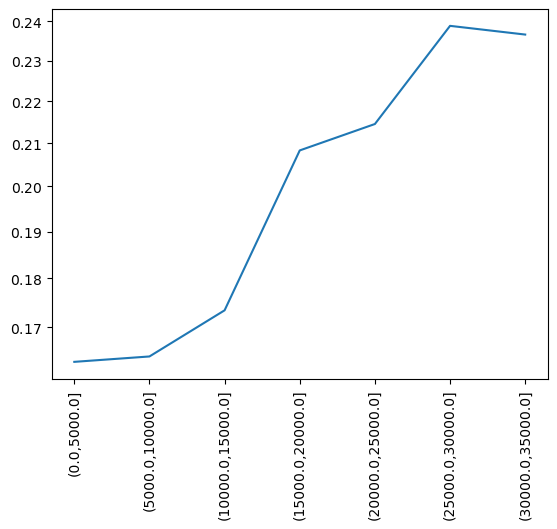

In [41]:
plt.xticks(rotation = 90)
plt.yscale("logit")
plt.plot(df["loan_amnt_cat"], df["mean_bad_loan"])

In [42]:
df

,loan_amnt_cat,nrow,mean_bad_loan
0,"(0.0,5000.0]",25785,0.163234
1,"(5000.0,10000.0]",50384,0.164278
2,"(10000.0,15000.0]",35552,0.173436
3,"(15000.0,20000.0]",24659,0.208281
4,"(20000.0,25000.0]",14447,0.214508
5,"(25000.0,30000.0]",6913,0.238825
6,"(30000.0,35000.0]",6247,0.236594


In [43]:
x_trans.remove("loan_amnt")
x_trans.append("loan_amnt_core")
x_trans.append("loan_amnt_delta")

train["loan_amnt_core"] = h2o.H2OFrame.ifelse(train["loan_amnt"] <= 5000, 5000, train["loan_amnt"])
train["loan_amnt_core"] = h2o.H2OFrame.ifelse(train["loan_amnt_core"] <= 30000, train["loan_amnt_core"], 30000)

train["loan_amnt_delta"] = train["loan_amnt"] - train["loan_amnt_core"]

### Converting Term to a 0/1 Indicator

Given that term of the loans are either 3 or 5 years, we will create a simplifed `term_36month` binary indicator that is 1 when the terms of the loan is for 5 years and 0 for loans with a term of 3 years.

In [44]:
train["term"].table()

term,Count
36 months,129950
60 months,34037


In [45]:
x_trans.remove("term")
x_trans.append("term_60months")

train["term_60months"] = train["term"] == "60 months"

In [46]:
train["term_60months"].table()

term_60months,Count
0,129950
1,34037


### Creating Missing Value Indicator for Employment Length

The most interesting characteristic about employment length is whether or not it is missing. The divide between those with missing values for employment length to those who have a recorded employment length is 26.3% bad loans to 18.0% bad loans respectively. Interestingly, there doesn't appear to be any differences in bad loans across employment lengths.

In [47]:
train["emp_length"].summary()

C:\Users\HP\AppData\Local\Temp\ipykernel_9312\141756057.py:1: H2ODeprecationWarning: ``summary()`` is deprecated, please use ``show_summary()`` or ``get_summary()`` instead
  train["emp_length"].summary()


,emp_length
type,int
mins,0.0
mean,5.68435293299533
maxs,10.0
sigma,3.6106637311002365
zeros,14248
missing,5804
0,10.0
1,0.0
2,10.0


In [48]:
x_trans.append("emp_length_missing")

train["emp_length_missing"] = train["emp_length"] == None

In [49]:
mean_target_encoding(train, "emp_length_missing")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


emp_length_missing,cv_fold,te_emp_length_missing
0,0,-1.52145
1,0,-1.03907
0,1,-1.51691
1,1,-1.02443
0,2,-1.51666
1,2,-1.05314
0,3,-1.51154
1,3,-1.02223
0,4,-1.51157
1,4,-1.01582


In [50]:
df = mean_target(train, "emp_length")

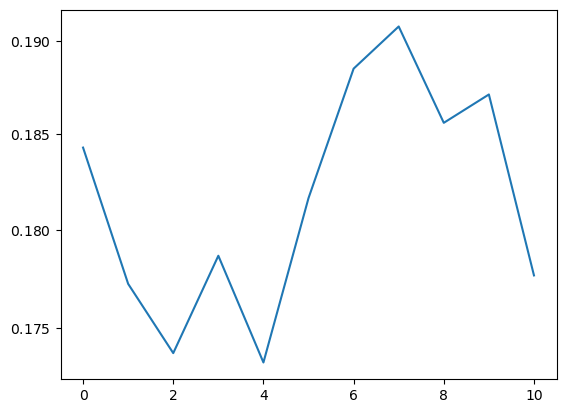

In [51]:
plt.yscale("logit")
plt.plot(df["emp_length"], df["mean_bad_loan"])

In [52]:
df

,emp_length,nrow,mean_bad_loan
0,NaN,0,0.262922
1,0.0,14248,0.184307
2,1.0,11414,0.177238
3,2.0,15766,0.173728
4,3.0,13611,0.178679
5,4.0,11024,0.173258
6,5.0,12347,0.181664
7,6.0,10000,0.188500
8,7.0,9079,0.190770
9,8.0,7424,0.185614


### Combining Categories in Home Ownership

Although there are 6 recorded categories within home ownership, only three had over 200 observations: OWN, MORTGAGE, and RENT. The remaining three are so infrequent we will combine them {ANY, NONE, OTHER} with RENT to form an enlarged OTHER category. This new `home_ownership_3cat` variable will have values in {MORTGAGE, OTHER, OWN}.

In [53]:
mean_target(train, "home_ownership")

,home_ownership,nrow,mean_bad_loan
0,ANY,1,0.000000
1,MORTGAGE,79714,0.164137
2,NONE,30,0.233333
3,OTHER,156,0.224359
4,OWN,13560,0.188348
5,RENT,70526,0.203273


In [54]:
lvls = ["OTHER", "MORTGAGE", "OTHER", "OTHER", "OWN", "OTHER"]
train["home_ownership_3cat"] = train["home_ownership"].set_levels(lvls).ascharacter().asfactor()

In [55]:
train[["home_ownership", "home_ownership_3cat"]].table()

home_ownership,home_ownership_3cat,Counts
ANY,OTHER,1
MORTGAGE,MORTGAGE,79714
NONE,OTHER,30
OTHER,OTHER,156
OWN,OWN,13560
RENT,OTHER,70526


In [56]:
mean_target(train, "home_ownership_3cat")

,home_ownership_3cat,nrow,mean_bad_loan
0,MORTGAGE,79714,0.164137
1,OTHER,70713,0.203329
2,OWN,13560,0.188348


In [57]:
x_trans.remove("home_ownership")
x_trans.append("home_ownership_3cat")

### Separating Typical from Extreme Annual Income

Looking at the occurance of bad loans on a logit scale reveal that the chance of a bad loan roughly decreases linearly in annual income from \$10,000 to \$105,000 and is relatively flat above \$105,000. To reflect this finding in the modeling, we will replace the original `annual_inc` measure with two derived measures:

\begin{eqnarray}
annual\_inc\_core & = & \max(10000, \min(annual\_inc, 105000)) \\
annual\_inc\_diff & = & annual\_inc - annual\_inc\_core
\end{eqnarray}

In [58]:
train["annual_inc"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,annual_incQuantiles
0,1896
0.05,27000
0.25,45000
0.5,61000
0.75,85000
0.95,145000
1,7.14178e+06


In [59]:
breaks = np.linspace(0, 150000, 31).tolist()
train["annual_inc_cat"] = train["annual_inc"].cut(breaks = breaks)

In [60]:
df = mean_target(train, "annual_inc_cat")

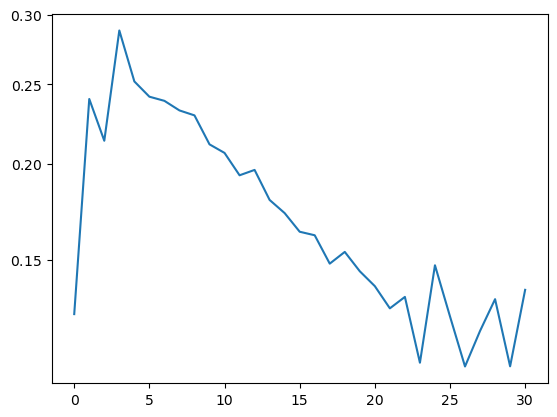

In [61]:
plt.yscale("logit")
plt.plot(df["annual_inc_cat"].index, df["mean_bad_loan"])

In [62]:
df[0:6]

,annual_inc_cat,nrow,mean_bad_loan
0,NaN,0,0.126695
1,"(0.0,5000.0]",25,0.240000
2,"(5000.0,10000.0]",192,0.213542
3,"(10000.0,15000.0]",868,0.288018
4,"(15000.0,20000.0]",1847,0.251760
5,"(20000.0,25000.0]",3975,0.241509


In [63]:
df[20:31]

,annual_inc_cat,nrow,mean_bad_loan
20,"(95000.0,100000.0]",5473,0.138315
21,"(100000.0,105000.0]",2860,0.129021
22,"(105000.0,110000.0]",3275,0.133740
23,"(110000.0,115000.0]",1908,0.108491
24,"(115000.0,120000.0]",3009,0.147557
25,"(120000.0,125000.0]",1741,0.125790
26,"(125000.0,130000.0]",1642,0.107186
27,"(130000.0,135000.0]",974,0.120123
28,"(135000.0,140000.0]",1235,0.132794
29,"(140000.0,145000.0]",746,0.107239


In [64]:
x_trans.remove("annual_inc")
x_trans.append("annual_inc_core")
x_trans.append("annual_inc_delta")

train["annual_inc_core"] = h2o.H2OFrame.ifelse(train["annual_inc"] <= 10000, 10000, train["annual_inc"])
train["annual_inc_core"] = h2o.H2OFrame.ifelse(train["annual_inc_core"] <= 105000,
                                               train["annual_inc_core"], 105000)

train["annual_inc_delta"] = train["annual_inc"] - train["annual_inc_core"]

### Creating Target Encoding for Loan Purpose

Given that there is a high concentration of loans for debt consolidation (56.87%), a sizable number for credit card (18.78%), and the remaining 24.35% loans are spread amongst 12 other purposes, we will use mean target encoding to avoid overfitting of the later group.

In [65]:
tbl = train["purpose"].table().as_data_frame()
tbl["Percent"] = np.round((100 * tbl["Count"]/train.nrows), 2)
tbl = tbl.sort_values(by = "Count", ascending = 0)
tbl = tbl.reset_index(drop = True)
print(tbl)

               purpose  Count  Percent
0   debt_consolidation  93261    56.87
1          credit_card  30792    18.78
2                other  10492     6.40
3     home_improvement   9872     6.02
4       major_purchase   4686     2.86
5       small_business   3841     2.34
6                  car   2842     1.73
7              medical   2029     1.24
8              wedding   1751     1.07
9               moving   1464     0.89
10               house   1245     0.76
11            vacation   1096     0.67
12         educational    418     0.25
13    renewable_energy    198     0.12


In [66]:
df = mean_target(train, "purpose")

In [67]:
df = df.sort_values(by = "mean_bad_loan", ascending = 0)
df = df.reset_index(drop = True)
df

,purpose,nrow,mean_bad_loan
0,small_business,3841,0.309034
1,renewable_energy,198,0.227273
2,other,10492,0.214354
3,educational,418,0.210526
4,moving,1464,0.207650
5,medical,2029,0.203056
6,debt_consolidation,93261,0.189479
7,house,1245,0.182329
8,vacation,1096,0.178832
9,credit_card,30792,0.157281


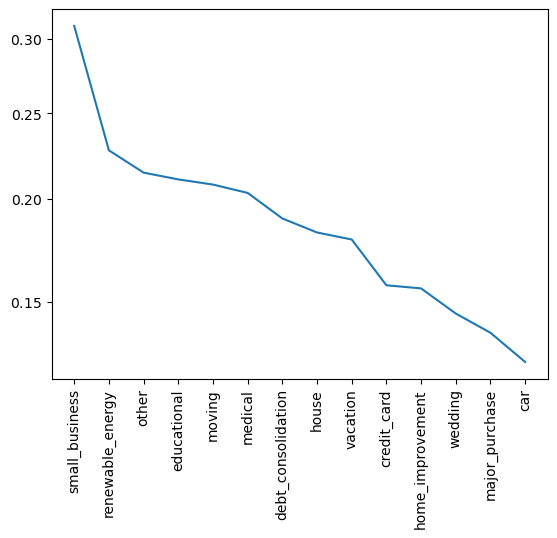

In [68]:
plt.xticks(rotation = 90)
plt.yscale("logit")
plt.plot(df["purpose"], df["mean_bad_loan"])

In [69]:
te_purpose = mean_target_encoding(train, "purpose")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [70]:
train = train.merge(te_purpose, all_x = True)

In [71]:
x_trans.remove("purpose")
x_trans.append("te_purpose")

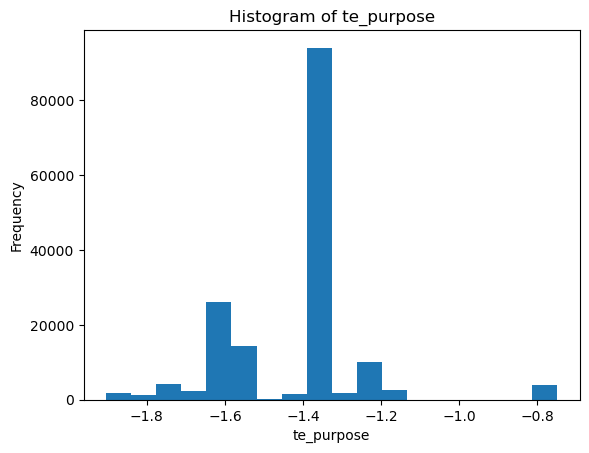

breaks,counts,mids_true,mids,widths
-1.93625,nan,nan,nan,nan
-1.87208,1695,-1.00021,-1.90416,0.0641741
-1.8079,1147,-0.956633,-1.83999,0.0641741
-1.74373,4120,-0.933019,-1.77582,0.0641741
-1.67956,2317,-0.897082,-1.71164,0.0641741
-1.61538,26242,-0.856468,-1.64747,0.0641741
-1.55121,14422,-0.836325,-1.58329,0.0641741
-1.48703,205,-0.782778,-1.51912,0.0641741
-1.42286,1419,-0.767386,-1.45495,0.0641741
-1.35868,94074,-0.740671,-1.39077,0.0641741


In [72]:
train["te_purpose"].hist()

### Creating Target Encoding for State of Residence

We will also use a mean target encoding for state of residence for a reason similar to that for purpose.

In [73]:
tbl = train["addr_state"].table().as_data_frame()
tbl["Percent"] = np.round((100 * tbl["Count"]/train.nrows), 2)
tbl = tbl.sort_values(by = "Count", ascending = 0)
tbl = tbl.reset_index(drop = True)
print(tbl[0:5])

  addr_state  Count  Percent
0         CA  28702    17.50
1         NY  14285     8.71
2         TX  12128     7.40
3         FL  11396     6.95
4         NJ   6457     3.94


In [74]:
df = mean_target(train, "addr_state")

In [75]:
df = df.sort_values(by = "mean_bad_loan", ascending = 0)
df = df.reset_index(drop = True)
print(df[0:5])

  addr_state  nrow  mean_bad_loan
0         NE    13       0.538462
1         TN  1327       0.238885
2         NV  2387       0.227901
3         MS   163       0.226994
4         IN  1463       0.217362


In [76]:
print(df[45:50])

   addr_state  nrow  mean_bad_loan
45         WV   714       0.131653
46         DC   584       0.114726
47         ID     9       0.111111
48         WY   376       0.109043
49         ME     3       0.000000


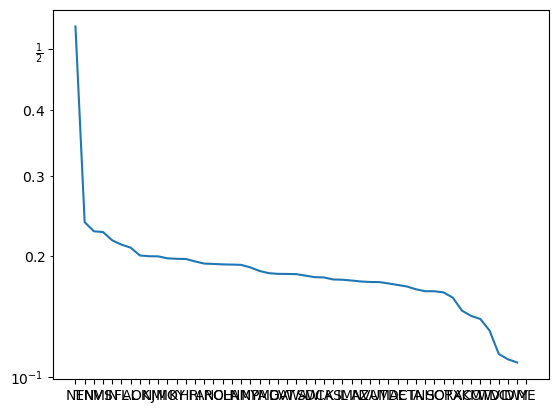

In [77]:
plt.yscale("logit")
plt.plot(df["addr_state"], df["mean_bad_loan"])

In [78]:
te_addr_state = mean_target_encoding(train, "addr_state", prior_count = 30)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [79]:
grouped_data = te_addr_state[["addr_state", "te_addr_state"]].group_by(["addr_state"])
df = grouped_data.count(na = "ignore").mean(na = "ignore").get_frame().as_data_frame()

In [80]:
df = df.sort_values(by = "mean_te_addr_state", ascending = 0)
df = df.reset_index(drop = True)

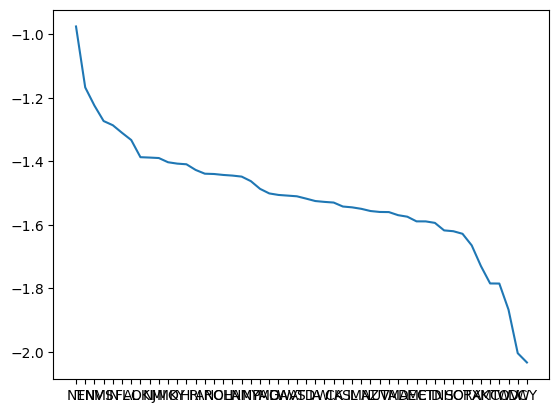

In [81]:
plt.plot(df["addr_state"], df["mean_te_addr_state"])

In [82]:
train = train.merge(te_addr_state, all_x = True)

In [83]:
x_trans.remove("addr_state")
x_trans.append("te_addr_state")

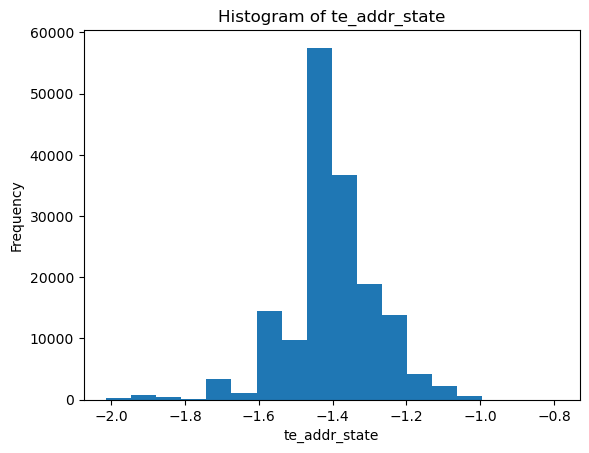

breaks,counts,mids_true,mids,widths
-2.04719,nan,nan,nan,nan
-1.97931,180,-1.05754,-2.01325,0.0678816
-1.91143,703,-1.01915,-1.94537,0.0678816
-1.84355,375,-0.985462,-1.87749,0.0678816
-1.77567,104,-0.925854,-1.80961,0.0678816
-1.70779,3423,-0.920484,-1.74173,0.0678816
-1.63991,1122,-0.885872,-1.67385,0.0678816
-1.57202,14477,-0.843086,-1.60596,0.0678816
-1.50414,9728,-0.818752,-1.53808,0.0678816
-1.43626,57525,-0.785532,-1.4702,0.0678816


In [84]:
train["te_addr_state"].hist()

### Separating Typical from Extreme Debt to Income Ratio

Looking at the occurance of bad loans on a logit scale reveal that the chance of a bad loan roughly increases linearly in debt-to-income from 5% to 30% and is highly volatile outside of that range due to small numbers of observations. To reflect this finding in the modeling, we will replace the original `dti` measure with two derived measures:

\begin{eqnarray}
dti\_core & = & \max(5, \min(dti, 30)) \\
dti\_diff & = & dti - dti\_core
\end{eqnarray}

In [85]:
train["dti"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,dtiQuantiles
0,0
0.05,3.79
0.25,10.23
0.5,15.62
0.75,21.26
0.95,29.02
1,39.99


In [86]:
breaks = np.linspace(0, 40, 41).tolist()
train["dti_cat"] = train["dti"].cut(breaks = breaks)

In [87]:
df = mean_target(train, "dti_cat")

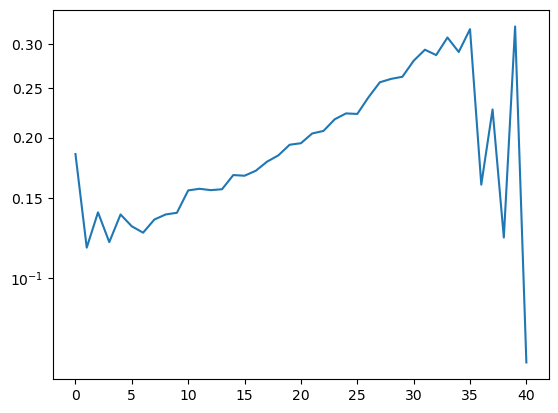

In [88]:
plt.yscale("logit")
plt.plot(df["dti_cat"].index, df["mean_bad_loan"])

In [89]:
df[30:41]

,dti_cat,nrow,mean_bad_loan
30,"(29.0,30.0]",2329,0.280378
31,"(30.0,31.0]",1496,0.293449
32,"(31.0,32.0]",1282,0.287051
33,"(32.0,33.0]",1051,0.308278
34,"(33.0,34.0]",1025,0.290732
35,"(34.0,35.0]",750,0.318667
36,"(35.0,36.0]",75,0.160000
37,"(36.0,37.0]",66,0.227273
38,"(37.0,38.0]",65,0.123077
39,"(38.0,39.0]",59,0.322034


In [90]:
x_trans.remove("dti")
x_trans.append("dti_core")
x_trans.append("dti_delta")

train["dti_core"] = h2o.H2OFrame.ifelse(train["dti"] <= 5, 5, train["dti"])
train["dti_core"] = h2o.H2OFrame.ifelse(train["dti_core"] <= 30, train["dti_core"], 30)

train["dti_delta"] = train["dti"] - train["dti_core"]

### Separating Typical from Extreme Number of Delinquencies in the Past 2 Years

The chance of a bad loan seems to max out at 3 delinquent payments in the past two years. To reflect this finding in the modeling, we will replace the original `delinq_2yrs` measure with two derived measures:

\begin{eqnarray}
delinq\_2yrs\_core & = & \min(delinq\_2yrs, 3) \\
delinq\_2yrs\_diff & = & delinq\_2yrs - delinq\_2yrs\_core
\end{eqnarray}

In [91]:
train["delinq_2yrs"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,delinq_2yrsQuantiles
0,0
0.05,0
0.25,0
0.5,0
0.75,0
0.95,1
1,29


In [92]:
breaks = np.linspace(0, 5, 6).tolist()
train["delinq_2yrs_cat"] = train["delinq_2yrs"].cut(breaks = breaks)

In [93]:
mean_target(train, "delinq_2yrs_cat")

,delinq_2yrs_cat,nrow,mean_bad_loan
0,NaN,0,0.181037
1,"(0.0,1.0]",17158,0.189299
2,"(1.0,2.0]",4635,0.201510
3,"(2.0,3.0]",1488,0.221774
4,"(3.0,4.0]",579,0.215889
5,"(4.0,5.0]",310,0.216129


In [94]:
x_trans.remove("delinq_2yrs")
x_trans.append("delinq_2yrs_core")
x_trans.append("delinq_2yrs_delta")

train["delinq_2yrs_core"] = h2o.H2OFrame.ifelse(train["delinq_2yrs"] <= 3, train["delinq_2yrs"], 3)

train["delinq_2yrs_delta"] = train["delinq_2yrs"] - train["delinq_2yrs_core"]

### Separating Typical from Extreme Revolving Credit Line Utilized

The relationship between credit line utilized is somewhat interesting. There appears to be a higher rate for a bad loan when 0% of the credit lines are utilized, then it drops down slightly and roughly increases linearly in credit line utilized up to 100%. To reflect this finding in the modeling, we will replace the original `revol_util` measure with three derived measures:

\begin{eqnarray}
revol\_util\_0 & = & I(revol\_util == 0) \\
revol\_util\_core & = & \max(5, \min(revol\_util, 30)) \\
revol\_util\_diff & = & revol\_util - revol\_util\_core
\end{eqnarray}

In [95]:
train["revol_util"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,revol_utilQuantiles
0,0
0.05,8.7
0.25,35.6
0.5,55.8
0.75,74.2
0.95,92.5
1,150.7


In [96]:
breaks = np.linspace(0, 120, 25).tolist()
train["revol_util_cat"] = train["revol_util"].cut(breaks = breaks)

In [97]:
df = mean_target(train, "revol_util_cat")

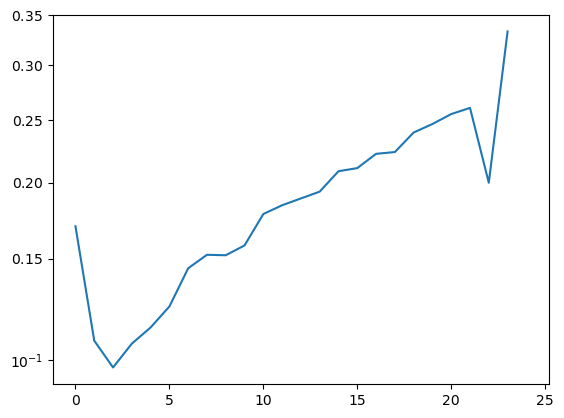

In [98]:
plt.yscale("logit")
plt.plot(df["revol_util_cat"].index, df["mean_bad_loan"])

In [99]:
df[20:25]

,revol_util_cat,nrow,mean_bad_loan
20,"(95.0,100.0]",4316,0.255097
21,"(100.0,105.0]",238,0.260504
22,"(105.0,110.0]",35,0.200000
23,"(110.0,115.0]",9,0.333333
24,"(115.0,120.0]",3,0.000000


In [100]:
x_trans.remove("revol_util")
x_trans.append("revol_util_0")
x_trans.append("revol_util_core")
x_trans.append("revol_util_delta")

train["revol_util_0"] = train["revol_util"] == 0

train["revol_util_core"] = h2o.H2OFrame.ifelse(train["revol_util"] <= 100, train["revol_util"], 100)

train["revol_util_delta"] = train["revol_util"] - train["revol_util_core"]

### Separating Typical from Extreme Number of Credit Lines

Looking at the occurance of bad loans on a logit scale reveal that the chance of a bad loan roughly decreases linearly in number of lines of credit up to about 50. To reflect this finding in the modeling, we will replace the original `total_acc` measure with two derived measures:

\begin{eqnarray}
total\_acc\_core & = & \min(total\_acc, 50) \\
total\_acc\_diff & = & total\_acc - total\_acc\_core
\end{eqnarray}

In [101]:
train["total_acc"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,total_accQuantiles
0,1
0.05,8
0.25,16
0.5,23
0.75,31
0.95,46
1,118


In [102]:
breaks = np.linspace(0, 60, 13).tolist()
train["total_acc_cat"] = train["total_acc"].cut(breaks = breaks)

In [103]:
df = mean_target(train, "total_acc_cat")

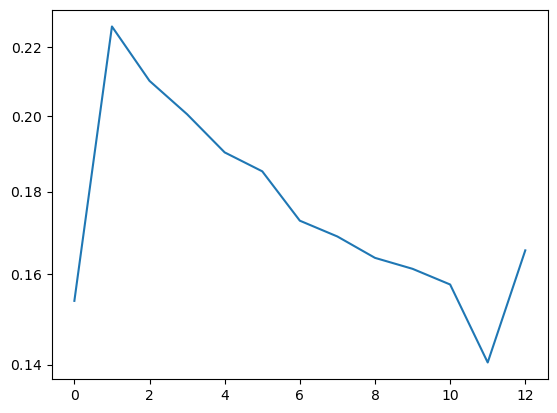

In [104]:
plt.yscale("logit")
plt.plot(df["total_acc_cat"].index, df["mean_bad_loan"])

In [105]:
(train["total_acc"] == None).table()

C1,Count
0,163958
1,29


In [106]:
df[0:3]

,total_acc_cat,nrow,mean_bad_loan
0,NaN,0,0.153788
1,"(0.0,5.0]",2309,0.226072
2,"(5.0,10.0]",12717,0.210034


In [107]:
df[8:13]

,total_acc_cat,nrow,mean_bad_loan
8,"(35.0,40.0]",11251,0.163719
9,"(40.0,45.0]",7174,0.161137
10,"(45.0,50.0]",4203,0.157507
11,"(50.0,55.0]",2350,0.140426
12,"(55.0,60.0]",1287,0.165501


In [108]:
x_trans.remove("total_acc")
x_trans.append("total_acc_core")
x_trans.append("total_acc_delta")

train["total_acc_core"] = h2o.H2OFrame.ifelse(train["total_acc"] <= 50, train["total_acc"], 50)

train["total_acc_delta"] = train["total_acc"] - train["total_acc_core"]

### Separating Typical from Extreme Longest Credit Length

Looking at the occurance of bad loans on a logit scale reveal that the chance of a bad loan roughly decreases linearly in longest credit length from 3 to 20 years and is highly volatile outside of that range due to small numbers of observations. To reflect this finding in the modeling, we will replace the original `longest_credit_length` measure with two derived measures:

\begin{eqnarray}
longest\_credit\_length\_core & = & \max(3, \min(longest\_credit\_length, 20)) \\
longest\_credit\_length\_diff & = & longest\_credit\_length - longest\_credit\_length\_core
\end{eqnarray}

In [109]:
train["longest_credit_length"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,longest_credit_lengthQuantiles
0,0
0.05,6
0.25,10
0.5,14
0.75,18
0.95,28
1,65


In [110]:
breaks = np.linspace(0, 25, 26).tolist()
train["longest_credit_length_cat"] = train["longest_credit_length"].cut(breaks = breaks)

In [111]:
df = mean_target(train, "longest_credit_length_cat")

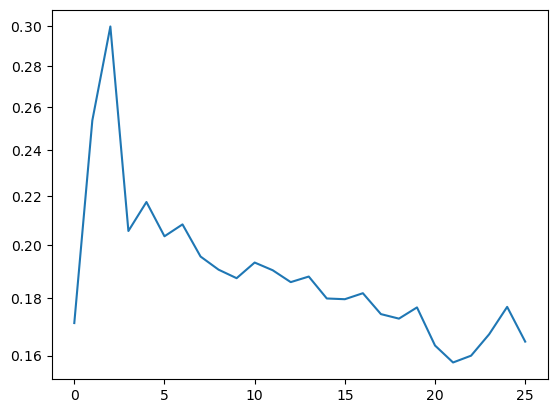

In [112]:
plt.yscale("logit")
plt.plot(df["longest_credit_length_cat"].index, df["mean_bad_loan"])

In [113]:
df[0:4]

,longest_credit_length_cat,nrow,mean_bad_loan
0,NaN,0,0.171094
1,"(0.0,1.0]",67,0.253731
2,"(1.0,2.0]",100,0.300000
3,"(2.0,3.0]",914,0.205689


In [114]:
df[20:26]

,longest_credit_length_cat,nrow,mean_bad_loan
20,"(19.0,20.0]",4682,0.163392
21,"(20.0,21.0]",3892,0.157760
22,"(21.0,22.0]",3350,0.160000
23,"(22.0,23.0]",3092,0.167206
24,"(23.0,24.0]",2856,0.176821
25,"(24.0,25.0]",2471,0.164711


In [115]:
x_trans.remove("longest_credit_length")
x_trans.append("longest_credit_length_core")
x_trans.append("longest_credit_length_delta")

train["longest_credit_length_core"] = h2o.H2OFrame.ifelse(train["longest_credit_length"] <= 3,
                                                          3, train["longest_credit_length"])
train["longest_credit_length_core"] = h2o.H2OFrame.ifelse(train["longest_credit_length_core"] <= 20,
                                                          train["longest_credit_length_core"], 20)

train["longest_credit_length_delta"] = train["longest_credit_length"] - train["longest_credit_length_core"]

### Converting Income Verification Status to a 0/1 Indicator

Given that incomes are either verified or not verified, we will create a simplifed `verified` binary indicator that is 1 when income has been verified.

In [116]:
train["verification_status"].table()

verification_status,Count
not verified,59155
verified,104832


In [117]:
x_trans.remove("verification_status")
x_trans.append("verified")

train["verified"] = train["verification_status"] == "verified"

In [118]:
train["verified"].table()

verified,Count
0,59155
1,104832


## Train Models Using Transformed Data

In [119]:
print(aml.leaderboard)

model_id                                                      auc    logloss     aucpr    mean_per_class_error      rmse       mse
StackedEnsemble_AllModels_3_AutoML_2_20221111_200845     0.708936   0.433632  0.346522                0.350163  0.369758  0.136721
StackedEnsemble_AllModels_2_AutoML_2_20221111_200845     0.708558   0.433788  0.346107                0.350899  0.369819  0.136766
StackedEnsemble_AllModels_1_AutoML_2_20221111_200845     0.708207   0.434035  0.345421                0.352214  0.369929  0.136847
StackedEnsemble_BestOfFamily_3_AutoML_2_20221111_200845  0.707334   0.434315  0.343825                0.353761  0.370063  0.136947
StackedEnsemble_BestOfFamily_4_AutoML_2_20221111_200845  0.707279   0.43441   0.343512                0.35216   0.370106  0.136979
StackedEnsemble_BestOfFamily_2_AutoML_2_20221111_200845  0.70712    0.434496  0.343713                0.352942  0.370136  0.137001
GBM_5_AutoML_2_20221111_200845                           0.706301   0.434988  0.341

In [120]:
print(x_trans)

['emp_length', 'loan_amnt_core', 'loan_amnt_delta', 'term_60months', 'emp_length_missing', 'home_ownership_3cat', 'annual_inc_core', 'annual_inc_delta', 'te_purpose', 'te_addr_state', 'dti_core', 'dti_delta', 'delinq_2yrs_core', 'delinq_2yrs_delta', 'revol_util_0', 'revol_util_core', 'revol_util_delta', 'total_acc_core', 'total_acc_delta', 'longest_credit_length_core', 'longest_credit_length_delta', 'verified']


In [121]:
# Set up AutoML

aml = H2OAutoML(max_runtime_secs=run_time)

In [122]:
model_start_time = time.time()
  
try:
  aml.train(x = x_trans, y = y, training_frame = train)  # Change training_frame=train
except Exception as e:
  logging.critical('aml.train') 
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()   
  sys.exit(4)
  
  
meta_data['model_execution_time'] = {"classification":(time.time() - model_start_time)} 

AutoML progress: |
20:15:06.357: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


In [123]:
d=meta_data['model_execution_time']
d['classification_trans']=(time.time() - model_start_time)
meta_data['model_execution_time'] = d

In [124]:
meta_data 

{'model_execution_time': {'classification': 224.29422569274902,
  'classification_trans': 230.71701645851135}}

In [125]:
print(aml.leaderboard)

model_id                                                      auc    logloss     aucpr    mean_per_class_error      rmse       mse
StackedEnsemble_AllModels_2_AutoML_3_20221111_201506     0.684687   0.443036  0.325614                0.367476  0.373336  0.13938
StackedEnsemble_AllModels_3_AutoML_3_20221111_201506     0.684637   0.443071  0.325463                0.366872  0.373353  0.139393
StackedEnsemble_AllModels_1_AutoML_3_20221111_201506     0.684561   0.443074  0.325427                0.367348  0.373357  0.139395
StackedEnsemble_BestOfFamily_3_AutoML_3_20221111_201506  0.683987   0.443297  0.324737                0.367766  0.373446  0.139462
StackedEnsemble_BestOfFamily_2_AutoML_3_20221111_201506  0.683916   0.443347  0.32436                 0.367748  0.373475  0.139483
GBM_2_AutoML_3_20221111_201506                           0.683125   0.443869  0.322344                0.367579  0.37371   0.139659
GBM_5_AutoML_3_20221111_201506                           0.682008   0.444445  0.3217

In [126]:
best_model_trans = h2o.get_model(aml.leaderboard[3,'model_id'])

## Shutdown H2O Cluster

In [128]:
h2o.cluster().shutdown()

H2O session _sid_9dc0 closed.
